# Imports

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
try:
  import ktrain
except:
  !pip install ktrain
  import ktrain
from ktrain import text
import time
from urllib.parse import urlparse
import pandas as pd
from keras.preprocessing.text import Tokenizer
import pickle
import json
import glob

2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pull and Extract the Diversity Articles Data

In [ ]:
#Pull the articles data
!wget https://s3.amazonaws.com/vargo.aprd6342/data/diversity-2021-02-09.tar.gz -P /content/drive/MyDrive/APRD6343/TextClassification

In [ ]:
#Extract the articles data

#X sets are for training to build model on (used to make predictions)
#Y sets are for testing to evaluate how model performs (contains the classified answers)
!tar -C /content/drive/MyDrive/APRD6343/TextClassification/ -zxvf /content/drive/MyDrive/APRD6343/TextClassification/diversity-2021-02-09.tar.gz

diversity-2021-02-09/
diversity-2021-02-09/x_test.p
diversity-2021-02-09/x_train.p
diversity-2021-02-09/y_train.p
diversity-2021-02-09/y_test.p


In [ ]:
ROOT_DIR = "/content/drive/MyDrive/APRD6343/TextClassification"
DATA_DIR = "%s/diversity-2021-02-09" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

In [ ]:
#Glob package looks in data directory and looks for all .p extension files and makes list of all paths
all_pickles = glob.glob("%s/*.p" % DATA_DIR)
all_pickles

['/content/drive/MyDrive/APRD6343/TextClassification/diversity-2021-02-09/x_test.p',
 '/content/drive/MyDrive/APRD6343/TextClassification/diversity-2021-02-09/x_train.p',
 '/content/drive/MyDrive/APRD6343/TextClassification/diversity-2021-02-09/y_train.p',
 '/content/drive/MyDrive/APRD6343/TextClassification/diversity-2021-02-09/y_test.p']

In [ ]:
#Create a dictionary to extract the file names and split it by backslash – only want last item in list after splitting (which is the name of the files, or the keys)
#For the keys, the article data will be the values
data_dict = {}
for a_pickle in all_pickles:
  file_name = a_pickle.split('/')[-1]
  data_dict[file_name] = pickle.load(open(a_pickle, 'rb'))

In [ ]:
#File names are the keys in the dictionary
data_dict.keys()

dict_keys(['x_test.p', 'x_train.p', 'y_train.p', 'y_test.p'])

In [ ]:
type(data_dict['x_train.p'])

list

In [ ]:
#Look at the first 5 values in the key x_train (news articles to train on)
data_dict['x_train.p'][0:5]

['Dodge Ram Truck Owners Sue Fiat Chrysler Over Engine Defect That Could Cause A Fire A lawsuit filed against Fiat Chrysler Automobiles (FCAU) by\xa0Dodge Ram 1500 truck owners claims that the automaker knowingly sold more than 100,000 trucks with a defect that could cause a fire.\nThe class-action lawsuit, which was filed on Thursday in the U.S. District Court for the Eastern District of Michigan, accused Fiat Chrysler of selling 2014 to 2019 Dodge Ram 1500 and 1500 Classic pickup trucks with a 3.0 L EcoDiesel engine with a potentially “grossly defective” exhaust gas recirculation cooler.\xa0\nAccording to the suit, the EGR coolers are susceptible to “thermal fatigue,” which could cause the coolers to crack over time and leak coolant. The plaintiffs claim that this can cause combustion within the intake manifold and lead to a truck fire or a sudden loss of power.\nAttorneys of the law firm Hagens Berman said that despite Fiat Chrysler\xa0issuing a recall over the potential defect, it 

In [ ]:
#Look at the first 5 values in the key y_train (labels of 1 if it is a pro-racial diversity article, 0 if it is not)
data_dict['y_train.p'][0:5]

[0, 0, 0, 1, 0]

# Test, Tune and Save Models

In [ ]:
#Ktrain allows the use of pretrained models available on huggingface
#Link to full list of models to use: https://huggingface.co/transformers/pretrained_models.html

In [ ]:
x_train = data_dict['x_train.p']
y_train = data_dict['y_train.p']
x_test = data_dict['x_test.p']
y_test = data_dict['y_test.p']
labels = [0,1]
target_names = list(set(labels))
#print('building Diversity model with %s examples'% (len(texts)))

In [ ]:
#Have to reset training each time, otherwise rerunning the notebook continues to tune the same model over and over
tf.keras.backend.clear_session()

#Maxlen is how many tokens to train on
#Class_names is labels
t = text.Transformer('bert-base-cased', maxlen=512, class_names=target_names)

#Preprocessing training and validation set, tweaking the epoch to find lowest loss after training
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner.lr_find(max_epochs=12)
#Looking for higher accuracy - this tries different learning rates and looks at how accuracy and loss change for each epoch


preprocessing train...
language: en
train sequence lengths:
	mean : 815
	95percentile : 2174
	99percentile : 5149


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 803
	95percentile : 2034
	99percentile : 4760



simulating training for different learning rates... this may take a few moments...
Epoch 1/12
1055/1055 [==============================] - 487s 441ms/step - loss: 0.7178 - accuracy: 0.4656
Epoch 2/12
1055/1055 [==============================] - 467s 443ms/step - loss: 0.4350 - accuracy: 0.8454
Epoch 3/12
1055/1055 [==============================] - 467s 442ms/step - loss: 0.2195 - accuracy: 0.9255
Epoch 4/12
1055/1055 [==============================] - 466s 442ms/step - loss: 0.1920 - accuracy: 0.9295
Epoch 5/12
1055/1055 [==============================] - 466s 441ms/step - loss: 0.2742 - accuracy: 0.8999
Epoch 6/12
1055/1055 [==============================] - 466s 442ms/step - loss: 0.6505 - accuracy: 0.6735
Epoch 7/12
1055/1055 [==============================] - 398s 377ms/step - loss: 0.6945 - accuracy: 0.6354


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


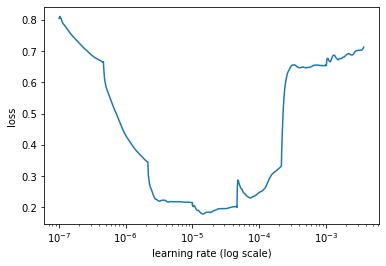

In [ ]:
#Pick optimal learning rate, where loss appears to be approximately the lowest for first time
learner.lr_plot()

In [ ]:
#1e-5 is the optimal learning rate according to the chart
tf.keras.backend.clear_session()
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner.autofit(1e-5, 20, early_stopping=True)
#20 is the epoch, or number of times to go through data - early_stopping stops the process when the model stops improving
validation = learner.validate(val_data=val)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/20
1056/1056 [==============================] - 522s 476ms/step - loss: 0.3849 - accuracy: 0.8389 - val_loss: 0.1804 - val_accuracy: 0.9268
Epoch 2/20
1056/1056 [==============================] - 500s 472ms/step - loss: 0.1701 - accuracy: 0.9377 - val_loss: 0.1598 - val_accuracy: 0.9419
Epoch 3/20
1056/1056 [==============================] - 499s 472ms/step - loss: 0.1518 - accuracy: 0.9477 - val_loss: 0.1675 - val_accuracy: 0.9362
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping
Weights from best epoch have been loaded into model.
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1093
           1       0.93      0.88      0.90       491

    accuracy                           0.94      1584
   macro avg       0.94      0.92      0.93      1584
weighted avg       0.94      0.94      0.94      1584



In [ ]:
#Save model to redeploy
predictor = ktrain.get_predictor(learner.model, preproc=t)
print("Saving best model...")
predictor.save('%s/diversity/' % (MODEL_DIR))
print("loading back in....")
predictor = ktrain.load_predictor('%s/diversity/' % (MODEL_DIR))
validation = learner.validate(val_data=val, print_report=True)

Saving best model...
loading back in....
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1093
           1       0.93      0.88      0.90       491

    accuracy                           0.94      1584
   macro avg       0.94      0.92      0.93      1584
weighted avg       0.94      0.94      0.94      1584



In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
#To classify random news articles - the darker the green, the more the token contributed
predictor.explain('Diversity is the key to a healthy society')

In [ ]:
predictor.explain('How PepsiCo plans to increase gender, racial diversity in management')

In [ ]:
predictor.explain('A patriotic education should include Black history')